In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, InputLayer, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback, CSVLogger

In [ ]:
!nvidia-smi

Mon Aug 14 03:27:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True)
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

  buffer_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  val_dataset = buffer_dataset.take(int(VAL_RATIO * DATASET_SIZE))

  test_dataset = buffer_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO=0.8, VAL_RATIO=0.1, TEST_RATIO=0.1)

In [ ]:
# print(f"Train Dataset Shape: {train_dataset.shape}")
# print(f"Val Dataset Shape: {val_dataset.shape}")
# print(f"Test Dataset Shape: {test_dataset.shape}")

In [ ]:
print(list(train_dataset.take(1).as_numpy_iterator()))
print(list(val_dataset.take(1).as_numpy_iterator()))
print(list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

## Data Visualization

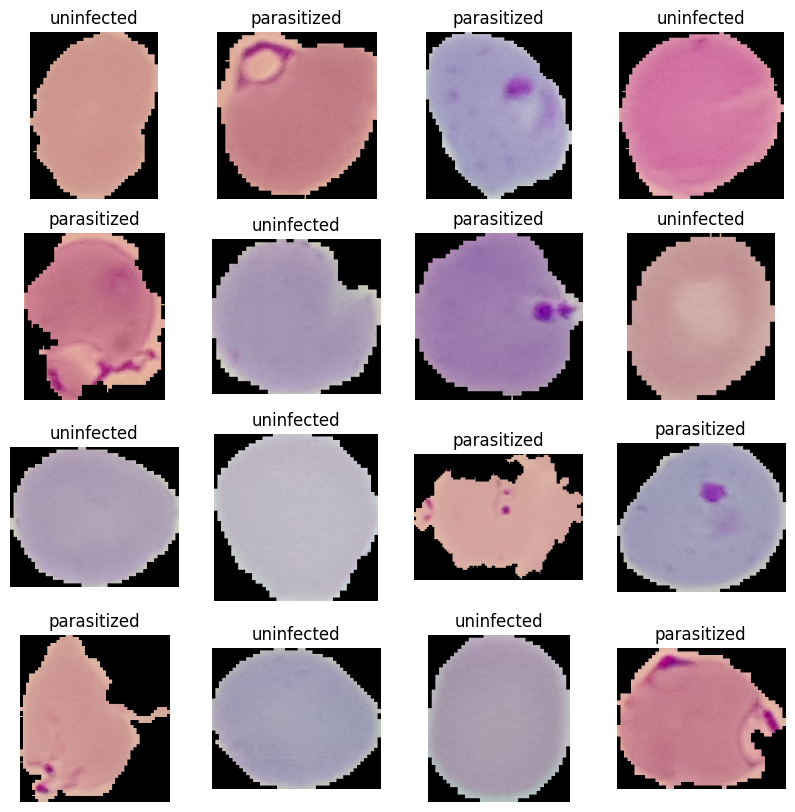

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

## Data Preprocessing

In [ ]:
IM_SIZE = 224

def resizing_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [ ]:
train_dataset = train_dataset.map(resizing_rescale)

In [ ]:
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [ ]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
BATCH_SIZE=32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
dropout_rate = 0.2

model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(
    l2=0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(
    l2=0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dropout(rate=dropout_rate),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     6

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics='accuracy')

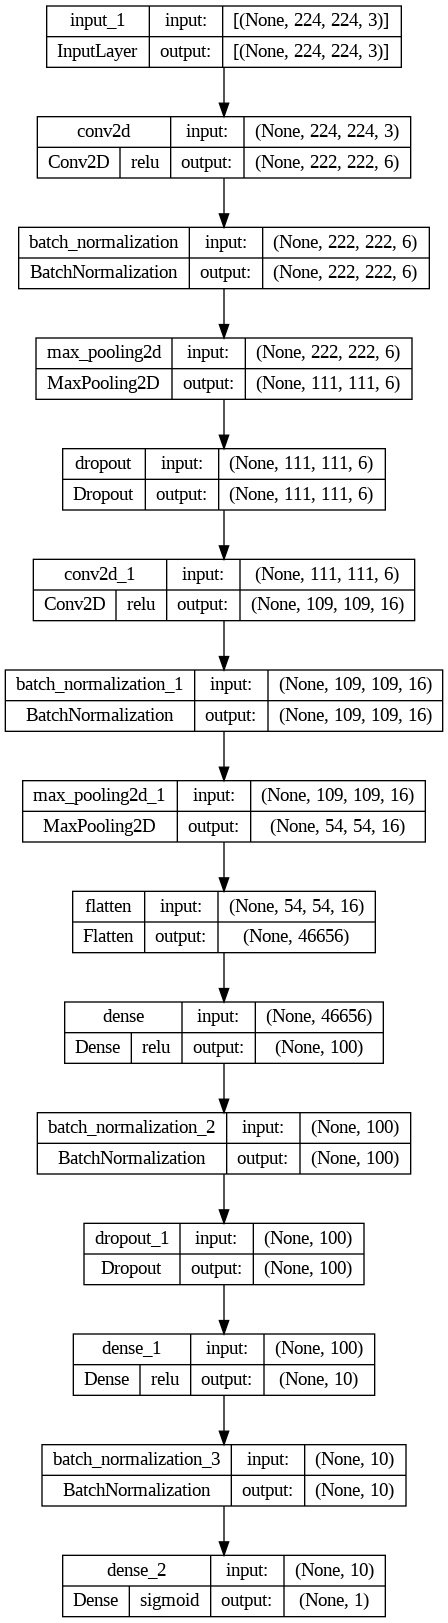

In [ ]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_layer_activations=True)

## Callbacks

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("For Epoch Number: {} the model has a loss of {}".format(epoch, logs['loss']))

  def on_batch_end(self, batch, logs):
    print("\nFor Batch Number {} the model has loss of {}".format(batch, logs['loss']))

## CSV Logger

In [ ]:
csv_logger = CSVLogger(
    'logs.csv',
    separator=',',
    append=False
)

## Early Stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0,
      patience=0,
      verbose=0,
      mode='auto',
      baseline=None,
      restore_best_weights=False,
      start_from_epoch=0
  )

## Learning Rate Schedular

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
lr_schedular = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Model Checkpoint

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                            filepath='/content/',
                                                            monitor = 'val_loss',
                                                            verbose = 0,
                                                            save_best_only = False,
                                                            save_weights_only = False,
                                                            mode = 'auto',
                                                            save_freq='epoch',
                                                            options=None,
                                                            initial_value_threshold=None,
                                                        )

## Reduce Learning Rate on Plateau

In [ ]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                                                              monitor='val_loss',
                                                              factor=0.01,
                                                              patience=10,
                                                              verbose=0,
                                                              mode='auto',
                                                              min_delta=0.0001,
                                                              cooldown=0,
                                                              min_lr=0,
                                                          )

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks=[
    # LossCallback(),
    # csv_logger,
    # early_stopping,
    # lr_schedular,
    checkpoint_callback,
    reduce_lr_on_plateau])

Epoch 1/10
688/689 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6647

689/689 [==============================] - 41s 60ms/step - loss: 0.6652 - accuracy: 0.6647 - val_loss: 0.6324 - val_accuracy: 0.6715 - lr: 0.1000
Epoch 2/10
689/689 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.6541

689/689 [==============================] - 42s 60ms/step - loss: 0.6859 - accuracy: 0.6541 - val_loss: 332.2520 - val_accuracy: 0.4254 - lr: 0.1000
Epoch 3/10
688/689 [============================>.] - ETA: 0s - loss: 0.6982 - accuracy: 0.6706

689/689 [==============================] - 42s 61ms/step - loss: 0.6980 - accuracy: 0.6708 - val_loss: 0.8170 - val_accuracy: 0.4838 - lr: 0.1000
Epoch 4/10
688/689 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.6575

689/689 [==============================] - 41s 59ms/step - loss: 0.6629 - accuracy: 0.6575 - val_loss: 23493.8887 - val_accuracy: 0.5187 - lr: 0.1000
Epoch 5/10
689/689 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.6818

689/689 [==============================] - 40s 58ms/step - loss: 0.6944 - accuracy: 0.6818 - val_loss: 570.6033 - val_accuracy: 0.4813 - lr: 0.1000
Epoch 6/10
688/689 [============================>.] - ETA: 0s - loss: 0.7133 - accuracy: 0.6453

689/689 [==============================] - 39s 57ms/step - loss: 0.7133 - accuracy: 0.6451 - val_loss: 1.0614 - val_accuracy: 0.4824 - lr: 0.1000
Epoch 7/10
688/689 [============================>.] - ETA: 0s - loss: 0.7233 - accuracy: 0.6617

689/689 [==============================] - 40s 59ms/step - loss: 0.7231 - accuracy: 0.6618 - val_loss: 2.5277 - val_accuracy: 0.4817 - lr: 0.1000
Epoch 8/10
688/689 [============================>.] - ETA: 0s - loss: 0.7932 - accuracy: 0.6465

689/689 [==============================] - 40s 57ms/step - loss: 0.7931 - accuracy: 0.6465 - val_loss: 0.9011 - val_accuracy: 0.5296 - lr: 0.1000
Epoch 9/10
688/689 [============================>.] - ETA: 0s - loss: 0.7477 - accuracy: 0.6277

689/689 [==============================] - 39s 57ms/step - loss: 0.7477 - accuracy: 0.6277 - val_loss: 1.2676 - val_accuracy: 0.5209 - lr: 0.1000
Epoch 10/10
689/689 [==============================] - ETA: 0s - loss: 0.7459 - accuracy: 0.6609

689/689 [==============================] - 40s 58ms/step - loss: 0.7459 - accuracy: 0.6609 - val_loss: 0.7182 - val_accuracy: 0.4831 - lr: 0.1000


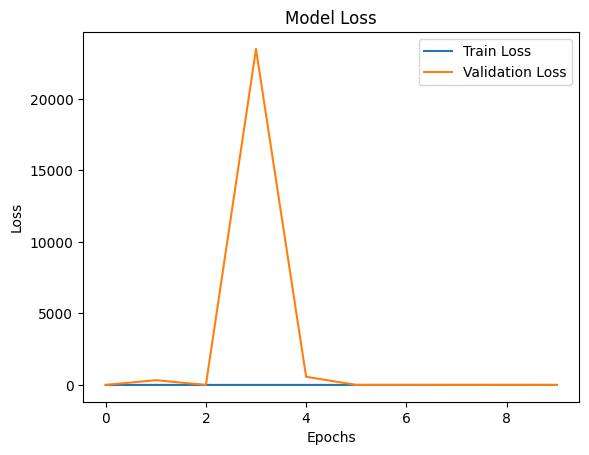

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6b6ef934-5786-e430-4303-2e04adb49f1f)


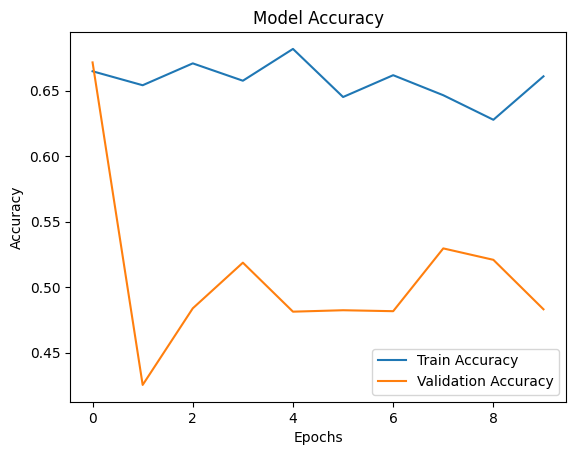

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.show()

## Model Evaluation and Testing

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
model.evaluate(test_dataset)

19291/19291 [==============================] - 74s 4ms/step - loss: 0.7086 - accuracy: 0.5034


[0.708620548248291, 0.5033953785896301]

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 27ms/step


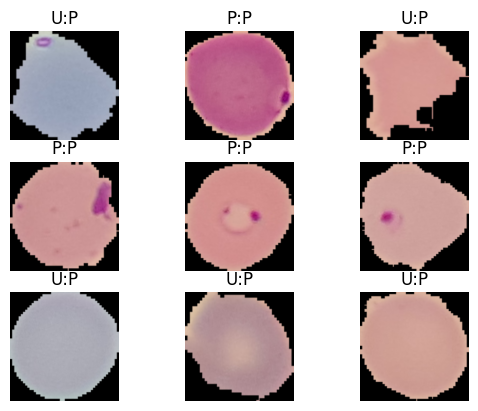

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0]) + ':' + str(parasite_or_not(model.predict(image)[0][0]))))
  plt.axis('off')

# Loading and Saving Model

In [ ]:
model.save("Model1")

In [ ]:
loaded_model = tf.keras.models.load_model('Model1')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     6

In [ ]:
model.save_weights("weights/model_weights")

In [ ]:
loaded_model.load_weights("weights/model_weights")